In [1]:
%load_ext line_profiler
from pyuvdata.uvdata.mir_parser import MirParser
import numpy as np
import matplotlib.pyplot as plt
from ozone import Ozone
from load_ac import stack_antenna_ac, moving_median_sliding


In [2]:
mir_data = MirParser("/Users/gkeating/data/SMA/ozone/211009_04:56:19", has_auto=True)
freq_range = [min(mir_data.sp_data['fsky']) - 2.0, max(mir_data.sp_data['fsky']) + 2.0]

In [3]:
ozone_model = Ozone('/Users/gkeating/newdata/', freq_range=freq_range)
pwv = 2
_ = ozone_model(zenith=0.1, pwv=pwv, return_pwv_jacobian=True)

In [4]:
freqs, stacked, elevation = stack_antenna_ac(
    mir_data,
    antenna_num=1,
    rx_num=0,
    normalization=False,
    return_el=True,
    spw_baselining=False,
    mad_dev=15.0,
    window_size=11,
)

In [5]:
model_arr = np.zeros_like(stacked)
za_arr = np.radians(90 - elevation)
model_freqs = ozone_model.data['freq']['map']
nspws = stacked.shape[1]
for idx, zenith in enumerate(za_arr):
    model_temps = ozone_model(pwv=pwv, zenith=zenith)[0][0, 0]
    for jdx, spw_freqs in enumerate(freqs):
        model_subarr = model_arr[idx, jdx]
        for sb_freqs, gain_fac in zip(spw_freqs, [1.0, 0.8]):
            model_subarr += np.interp(sb_freqs, model_freqs, model_temps) * gain_fac

In [6]:
old_stack = stacked * 1
tsys = 80
new_stack = stacked / (model_arr+tsys)

for item in [old_stack, new_stack]:
    item /= np.nanmedian(item,axis=0)[None]
    item /= np.nanmedian(item,axis=2)[:, :, None]

/var/folders/6k/9m18n_s947n5ts95gb8v5v180000gn/T/ipykernel_25601/1002048134.py:6: RuntimeWarning: All-NaN slice encountered
  item /= np.nanmedian(item,axis=0)[None]


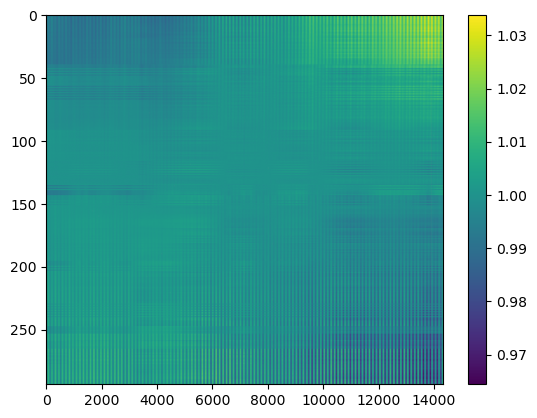

In [7]:
plt.imshow(new_stack[np.argsort(elevation), 3, :], aspect='auto')
plt.colorbar()

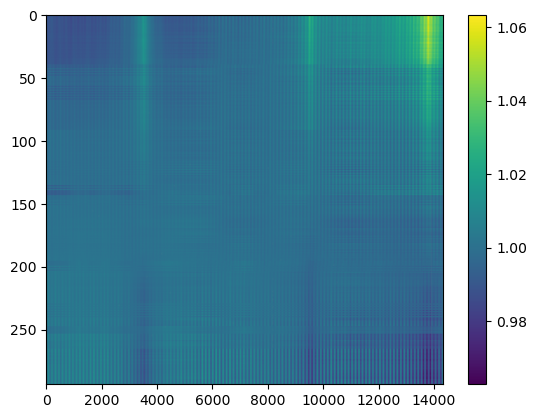

In [8]:
plt.imshow(old_stack[np.argsort(elevation), 3, :], aspect='auto')
plt.colorbar()

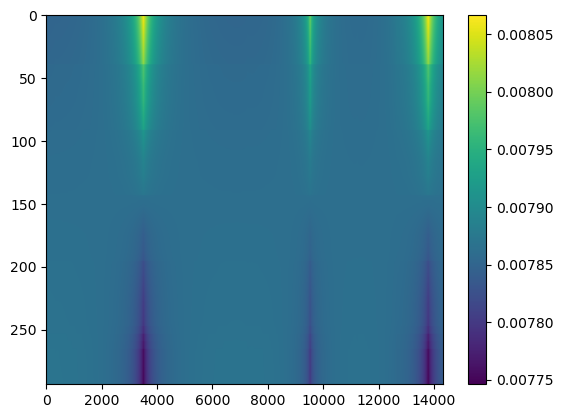

In [9]:
plt.imshow(
    (
        ((model_arr[np.argsort(elevation), 3, :] + tsys)
            / np.median(model_arr[np.argsort(elevation), 3, :] + tsys, axis=1)[:, None])
            / np.median(model_arr[np.argsort(elevation), 3, :] + tsys, axis=0)
    ),
    aspect='auto')
plt.colorbar()

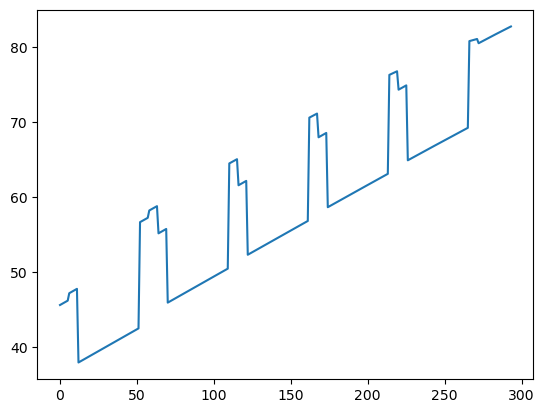

In [10]:
plt.plot(elevation)

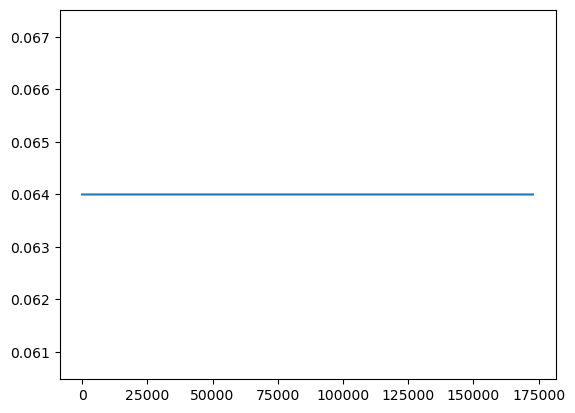

In [11]:
plt.plot(mir_data.sp_data['tau0'])